# Gradient descent to minimize the logarithmic energy of $n$ points

The algorithm works on the manifold given by the product of $n$ spheres, using the package pymanopt.

The stepsize in the tangent space is calculated with Armijo rule.

12/24 - 01/26. Initial code MF.

In [1]:
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
# from scipy.special import binom, comb, gamma

!pip install pymanopt
import pymanopt as pym
from pymanopt.manifolds import Product, Sphere


# Auxiliary functions

In [3]:
######
# Plots points in the sphere S^2.
# z is an nx3 matriz, were each row has the cartesian coordinates of a different point. 
######
def plot_points(z):
    pi = np.pi
    cos = np.cos
    sin = np.sin
    
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]

    # plot the sphere
    xx = sin(phi)*cos(theta)
    yy = sin(phi)*sin(theta)
    zz = cos(phi)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, zz,  rstride=1, cstride=1, color='c', alpha=0.5, linewidth=0.5)

    # plot the points given by z
    ax.scatter(z[:,0], z[:,1], z[:,2], s=50)


# Logarithmic Energy and its Gradient in ambient space

In [4]:
#####
# Logarithmic energy.
# w is an nxd matrix, were row i has the cartesian coordinates of the point i.
#####
def funElog(w):
    w = np.array(w)
    n = len(w)

    f = 0
    for i in range(n): # each point
        Di = w - w[i,:] # array with values wk-wi for each k
        di = np.sqrt( np.sum(Di**2, axis=1) ) # array with values |wk-wi|^2 for each k
        di[i] = 1
        
        f += np.sum( -np.log(di) )
  
    return 0.5 * f

#####
# Gradient in ambient space of the log energy.
#####
def gradElog(w):
    w = np.array(w) # matrix of points w[i,:] (one row per point)
    n, m = w.shape
    
    g = np.zeros(w.shape) # matrix with gradient wrt each point w[i,:]

    # for each point w[i,:]
    # adds the term related to w[i,:] to the derivative wrt the other points.
    for i in range(n):
        Di = w - w[i,:] # wk-wi for each k
        Ni = np.sum( Di**2, axis=1 ) # squared norm
        
        Ni[i] = 1 # avoid NaN (Ni[i]=0 in previous line)

        gi = - ( Di.T / Ni ).T # divide each row of Di by Ni
        g += gi
      
    return g



# Gradient Descent in the Product of Spheres

Stepsize is calculated with Armijo rule.

The projection of the ambient space gradient onto the tangent space, and the retraction of the new estimation to the sphere are implemented in the package *pymanopt*.

In [5]:
######
# Gradient Descent in the product of spheres, with initial configuration w.
######
def grad_descent(manifold, w, function, gradient, maxIters=100, tolGrad=1e-4):
    w = np.array(w)

    # Armijo parameters
    b = 0.3; sigma = 0.1; t = 0.1
  
    grad = gradient(w)
    # grnorminit = la.norm( manifold.projection(w, grad) )

    k = 0
    while k < maxIters and la.norm( manifold.projection(w, grad) ) > tolGrad :
        grad = gradient(w)

        # Calculate step with Armijo
        while ( function( manifold.retraction(w, -grad*t) ) > function(w) - sigma*t*la.norm(manifold.projection(w, grad))**2 ):
          t = b*t
        
        w = manifold.retraction(w, -grad*t)
        t = t / b

        # print( function(w) ) # functional value
        # print( la.norm( manifold.projection(w, grad) ) ) # norm of gradient in the tangent space
        # print(grad)
        
        k = k+1

    if k >= maxIters :
        print('\nWARNING: GD reached the maximum number of iterations.')

    return w, k


# Apply Gradient Descent with initial random configuration

Initial configuration $w_{init}$ is a random configuration on the product of spheres obtained with pymanopt.


Number of points: n = 7

Dimension of AMBIENT space: d = 3

Maximum iterations: 3689

Tolerance on norm of projected gradient: 1e-05

Number of tests: 5

----------------

Test number 1 of 5...

Test number 2 of 5...

Test number 3 of 5...

Test number 4 of 5...

Test number 5 of 5...


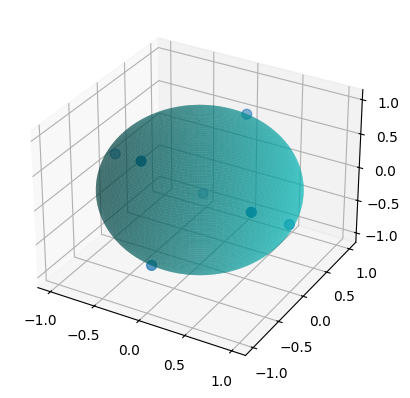

In [98]:
#####
# Parameters
#####
N = 7 # number of points
d = 3 # AMBIENT space dimension. Spheres $S^{d-1} \subset \mathbb{R}^d$.

verboseGD = 0 # 1 to show final values of each test.

tolProjGradNorm = 1e-5 # stops if norm of projected gradient is less or equal

maxIters = int( 5 * N / ( d * np.sqrt(tolProjGradNorm) ) ) # maximum number of iterations of GD.

Ntests = 5 # number of tests with different initial configuration
######
# N=7: S^2, Ntests=1000; S^3, Ntests=5000; S^4, Ntests=10.000; S^5, Ntests=50.000.
######

print('\nNumber of points: n = ' + str(N) )
print('\nDimension of AMBIENT space: d = ' + str(d) )

print('\nMaximum iterations: ' + str(maxIters) )
print('\nTolerance on norm of projected gradient: ' + str(tolProjGradNorm) )

print('\nNumber of tests: ' + str(Ntests) )
print('\n----------------')

#####
# Define the manifold as the product of N spheres.
#####
manilist = []
for _ in range(N): # for each point
    manilist.append(Sphere(d)) # add a new sphere

manifold = Product(manilist) # take the product manifold

#####
# Tests.
#####
Niters = [] # number of iterations of each test
Einitial = [] # list with initial energy of each test
Efinal = [] # list with final energy of each test

Energies = [] # list with the different values of energies, up to 7 digits
Confs = [] # list with the respective configurations of Energies

numOneDipole = 0 # number of configurations with exactly one dipole

Conf4S13S1 = 0 # times configuration 4_{S^1} x 3_{S^1} is found in S^3 for N=7

for k in range(Ntests): # each test
    print('\nTest number ' + str(k+1) + ' of ' + str(Ntests) + '...' )

    ########
    # Initial random configuration.
    ########
    winit =  manifold.random_point() # initial random configuration in the manifold.
    
    ########
    # Apply GD to minimize Elog.
    ########
    w, iters = grad_descent(manifold, winit, funElog, gradElog, maxIters, tolProjGradNorm)

    ######
    # Save final values
    ######
    Niters.append(iters)
    Einitial.append(funElog(winit))
    Efinal.append(funElog(w))

    ######
    # Save configuration if energy value is new.
    ######
    EfinalRound = np.round(Efinal[-1], 7) # round final energy to 7 digits
    
    if not ( EfinalRound in Energies ) : # if not in list with rounded Energies
        Energies.append(EfinalRound) # save new energy value
        Confs.append(w) # save configuration

    ######
    # For n=7 and S^2, try to find exactly ONE dipole.
    ######
    if N==7 and d==3 :
        W = np.array(w) # convert to array

        Y = np.round( W @ W.T, 2 ) # dot product matrix rounded
        # print(Y)
    
        indP = np.where(Y==-1)[0] # try to find index of rows with value -1
        # print(indP)

        if len(indP) == 2 : # exactly one dipole found
            numOneDipole += 1 # add to number of dipoles
        else :
            print("\nWARNING: No dipole found (or more than one).")
            print(indP) # show dipoles index

    ######
    # For n=7 and S^3, try to find configuration 4_{S^2} x 3_{S^1}.
    # This conf. has exactly 2 dipoles in an S^1, and a 3 point simplex in another S^1, orthogonal to each other.
    # 
    # Let W be the cartesian coordinates matrix and Y = W * W^T the dot product matrix. What we do is try to:
    # 1. Find exactly 4 rows in Y with a -1, and
    # 2. Check that every row with a -1 has null non diagonal entries, and
    # 3. Check that the other rows have the dot product matrix of a 2-simplex.
    ######
    if N==7 and d==4 :
        W = np.array(w) # convert to array

        Y = np.round( W @ W.T, 2 ) # dot product matrix rounded
        # print(Y)
        
        indP = np.where(Y==-1)[0] # try to find index of rows with value -1
        # print(indP)

        ######
        # Check if the configuration is 4_{S^1} x 3_{S^1}
        ######
        if len(indP) == 4 : # exactly 4 rows with a -1 found

            #######
            # Check if every row with a -1 has null non diagonal entries.
            #######
            flag1 = True
            for rowY in indP : # each row in indP
                flag1 = flag1 and ( np.count_nonzero(Y[rowY]) == 2 )

            ######
            # Check if the other rows have the dot product matrix of a 2-simplex
            ######
            comp = np.delete(range(N), indP) # complement (0:N-1) \ indP
            # print(comp)

            # select rows of matrix W of Cartesian coordinates without a -1
            YC = np.round(W[comp] @ W[comp].T, 3) # complement dot prod matrix
            
            # YC should be [[1, -0.5, -0.5], [-0.5, 1, -0.5], [-0.5, -0.5, 1]]
            flag2 = np.linalg.norm( YC - ( -0.5 * np.ones((3,3)) + 1.5 * np.eye(3) ) ) < 1e-5

            if flag1 and flag2 :
                Conf4S13S1 += 1 # increment times this configuration is found

        else :
            print("\nWARNING: No or just one dipole found.")
            print(indP) # show dipoles index
    
    ######
    # Show final values (if verbose=1).
    ######
    if verboseGD == 1 :
        print('\nNumber of iterations: ' + str(Niters[-1]) + ' of ' + str(maxIters) )
    
        print('\nLogarithmic Energy:')
        print(' -- in w initial : ',  Einitial[-1])
        print(' -- in w final   : ', Efinal[-1] )
    
        print('\n----------------')

######
# Plot points in S^2.
######
if d==3:
    plot_points( np.array(w) )



## Different Energy values and their respective configurations

In [99]:
print('\nNumber of points: n = ' + str(N) )
print('\nDimension of AMBIENT space: d = ' + str(d) )

print("\nNumber of tests: ", Ntests)

print("\nNumber of configurations with exatcly 1 dipole: ", numOneDipole)

print("\nNumber of configurations $4_{S^1} x 3_{S^1}$: ", Conf4S13S1)

print('\nEnergy values found:')
print(Energies)

print('\nDot product matrix associated to each energy value:')

for W in Confs:
    W = np.array(W)

    print('\nDot product matrix:')
    print( np.round( W @ W.T, 3) )



Number of points: n = 7

Dimension of AMBIENT space: d = 3

Number of tests:  5

Number of configurations with exatcly 1 dipole:  5

Number of configurations $4_{S^1} x 3_{S^1}$:  0

Energy values found:
[np.float64(-8.1824773)]

Dot product matrix associated to each energy value:

Dot product matrix:
[[ 1.    -0.81  -0.807  0.309 -0.017  0.018  0.308]
 [-0.81   1.     0.309 -0.807  0.018 -0.018  0.308]
 [-0.807  0.309  1.     0.309 -0.03   0.028 -0.809]
 [ 0.309 -0.807  0.309  1.     0.028 -0.029 -0.809]
 [-0.017  0.018 -0.03   0.028  1.    -1.     0.   ]
 [ 0.018 -0.018  0.028 -0.029 -1.     1.     0.001]
 [ 0.308  0.308 -0.809 -0.809  0.     0.001  1.   ]]


## Histogram of final values

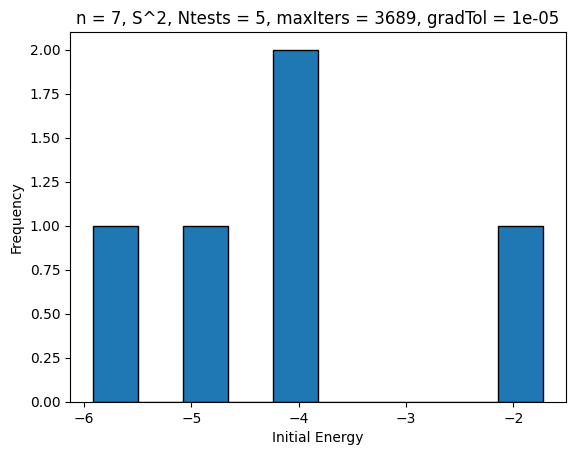

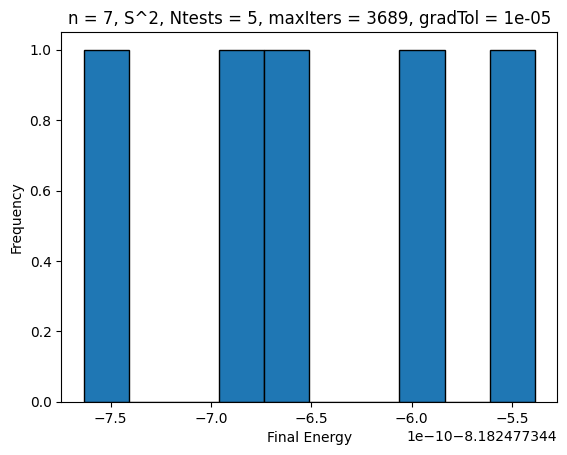

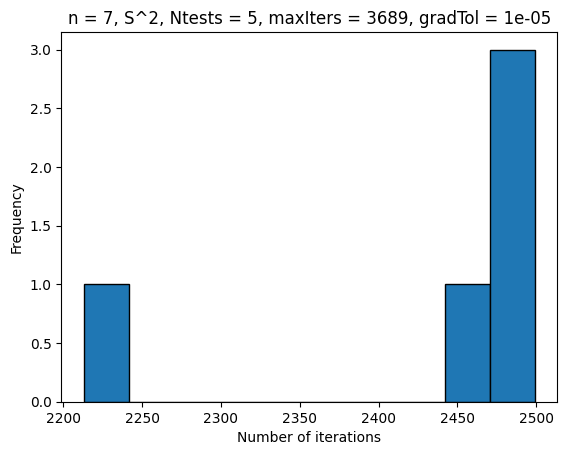

In [100]:
import matplotlib.pyplot as plt

plt.hist(Einitial, edgecolor='black')
plt.xlabel('Initial Energy')
plt.ylabel('Frequency')
plt.title('n = ' + str(N) + ', S^' + str(d-1) + ', Ntests = ' + str(Ntests) + 
          ', maxIters = ' + str(maxIters) + ', gradTol = ' + str(tolProjGradNorm) )
plt.show()

plt.hist(Efinal, edgecolor='black')
plt.xlabel('Final Energy')
plt.ylabel('Frequency')
plt.title('n = ' + str(N) + ', S^' + str(d-1) + ', Ntests = ' + str(Ntests) + 
          ', maxIters = ' + str(maxIters) + ', gradTol = ' + str(tolProjGradNorm) )
plt.show()

plt.hist(Niters, edgecolor='black')
plt.xlabel('Number of iterations')
plt.ylabel('Frequency')
plt.title('n = ' + str(N) + ', S^' + str(d-1) + ', Ntests = ' + str(Ntests) + 
          ', maxIters = ' + str(maxIters) + ', gradTol = ' + str(tolProjGradNorm) )
plt.show()


## Final Energy value frequencies

In [11]:
from collections import Counter

print('\nFrequencies of each final energy value:')
Counter( np.round(Efinal, 7) )



Frequencies of each final energy value:


Counter({np.float64(-8.5793902): 5})